In [1]:
# Importing packages
import requests  
import pandas as pd
import sklearn
import nltk
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.feature_extraction import text
from sklearn.metrics import ConfusionMatrixDisplay
from nltk.stem import WordNetLemmatizer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import svm
import time

In [2]:
#Import the data frame
mtg = pd.read_csv("MTG_Cards")
mtg = mtg.drop(columns = "Unnamed: 0")
mtg

,Name,Text,Flavor,Color,Cost,Type,Rarity
0,+2 Mace,Equipped creature gets +2/+2 Equip {3} {3}: At...,The weight of this magic weapon falls heavy on...,White,{1}{W},Artifact — Equipment,common
1,Abbey Gargoyles,Flying protection from red,Though Serra has not been seen for twenty year...,White,{2}{W}{W}{W},Creature — Gargoyle,uncommon
2,Abbey Griffin,Flying vigilance,The darkness crawls with vampires and ghouls b...,White,{3}{W},Creature — Griffin,common
3,Abbey Matron,{W} {T}: Abbey Matron gets +0/+3 until end of ...,The Matrons are kindly souls but don t ask one...,White,{2}{W},Creature — Human Cleric,common
4,Abeyance,Until end of turn target player can t cast ins...,I m too modest a wizard to reveal the full ext...,White,{1}{W},Instant,rare
...,...,...,...,...,...,...,...
12039,Wolf's Quarry,Create three 1/1 green Boar creature tokens wi...,The monster was gaining on them Twice it had f...,Green,{4}{G}{G},Sorcery,common
12040,Wolf Strike,Target creature you control gets +2/+0 until e...,Tovolar s howlpack had scattered but the Dire ...,Green,{2}{G},Instant,common
12041,Wolverine Pack,Rampage 2 Whenever this creature becomes block...,Give them great meals of beef and iron and ste...,Green,{2}{G}{G},Creature — Wolverine,uncommon
12042,Wolverine Riders,At the beginning of each upkeep create a 1/1 g...,We ll break their lines The rest of you follow,Green,{4}{G}{G},Creature — Elf Warrior,rare


In [3]:
## Preparing Data for Vectorization ##

In [4]:
#Initializing empty lists to hold the card texts and colors
TextList = []
ColorList = []

In [5]:
#Filling the lists with the elements from the data frame
for text, color in zip(mtg["Text"], mtg["Color"]):
    TextList.append(text)
    ColorList.append(color)

In [6]:
print(TextList[:5])

['Equipped creature gets +2/+2 Equip {3} {3}: Attach to target creature you control Equip only as a sorcery', 'Flying protection from red', 'Flying vigilance', '{W} {T}: Abbey Matron gets +0/+3 until end of turn', 'Until end of turn target player can t cast instant or sorcery spells and that player can t activate abilities that aren t mana abilities Draw a card']


In [7]:
#Cleaning the text
CleanTextList = []

for text in TextList:

    text=re.sub(r'[,:.\+;@#?!&$\-\\{\}\\\/\']+', ' ', text, flags=re.IGNORECASE)
    text=re.sub(' +', ' ', text, flags=re.IGNORECASE)
    text=re.sub(r'\"', ' ', text, flags=re.IGNORECASE)
    text=re.sub(r'[^a-zA-Z]', " ", text, flags=re.VERBOSE)
    text=text.replace(',', '')
    text=' '.join(text.split())
    text=re.sub("\n|\r", "", text) 
    text = ' '.join([wd for wd in text.split() if len(wd)>2])
    
    CleanTextList.append(text)

In [8]:
print(CleanTextList[:5])

['Equipped creature gets Equip Attach target creature you control Equip only sorcery', 'Flying protection from red', 'Flying vigilance', 'Abbey Matron gets until end turn', 'Until end turn target player can cast instant sorcery spells and that player can activate abilities that aren mana abilities Draw card']


In [9]:
mtgColors = ["red", "black", "blue", "green", "white"]

In [10]:
#Initializing another list
CleanTextListNoColors = []

In [11]:
#Removing any words that match the target variables to avoid confusion or overfitting
for text in CleanTextList:
    AllWords = text.split(" ")
    NewWordsList = []
    for word in AllWords:
        word = word.lower()
        if word not in mtgColors:
            NewWordsList.append(word)
    NewWords = " ".join(NewWordsList)
    CleanTextListNoColors.append(NewWords)

In [12]:
print(CleanTextListNoColors[:5])

['equipped creature gets equip attach target creature you control equip only sorcery', 'flying protection from', 'flying vigilance', 'abbey matron gets until end turn', 'until end turn target player can cast instant sorcery spells and that player can activate abilities that aren mana abilities draw card']


In [13]:
#Getting the default list of English stop words used in the CountVectorizer functions
sets = [sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]

In [14]:
#Creating a new list that is not a frozen set so it can be edited
stop_words = [list(x) for x in sets]
stop_words = stop_words[0]
print(stop_words)

['during', 'ltd', 'where', 'first', 'to', 'next', 'mostly', 'hundred', 'ourselves', 'cry', 'up', 'then', 'less', 'hers', 'done', 'down', 'thick', 'indeed', 'everywhere', 'hasnt', 'being', 'twenty', 'upon', 'eight', 'whose', 'elsewhere', 'yourselves', 'was', 'you', 'this', 'should', 'five', 'towards', 'that', 'however', 'toward', 'it', 'thereupon', 'third', 'ever', 'from', 'much', 'other', 'would', 'hereupon', 'ten', 'us', 'why', 'eg', 'former', 'often', 'except', 'further', 'cant', 'besides', 'in', 'therefore', 'namely', 'six', 'too', 'mill', 'serious', 'also', 'anyway', 'call', 'will', 'could', 'bottom', 'only', 'least', 'as', 'sincere', 'never', 'are', 'nine', 'most', 'such', 'seem', 'their', 'someone', 'none', 'all', 'these', 'his', 'due', 'out', 'moreover', 'sometimes', 'thus', 'twelve', 'else', 'its', 'how', 'might', 'hereafter', 'nobody', 'even', 'last', 'amount', 'whereupon', 'we', 'detail', 'nevertheless', 'each', 'seeming', 'meanwhile', 'her', 'again', 'mine', 'still', 'those'

In [15]:
CommonMTGWords = ["target", "creature", "control", "battlefield", "turn", "end", "opponent",
                 "player", "card", "artifact", "cast", "counter", "spell"]

In [16]:
for word in CommonMTGWords:
    stop_words.append(word)

In [17]:
# Creating instances of Count Vectorizer

#Since CountVectorizer Binary scored highest in unigram MNB and SVM it will be compared against bigram version

#TfidfVectorizers for MultinomialNB
CV350b = CountVectorizer(input = "content", stop_words = stop_words, binary = True,
                         ngram_range = (1,2), max_features = 350)

In [18]:
#Fitting the count vectorizer
CVs_350b_bigram = CV350b.fit_transform(CleanTextListNoColors)
colnames_350b_bigram = CV350b.get_feature_names_out()

In [19]:
#Making the data frame
DF_CV350b_bigram = pd.DataFrame(CVs_350b_bigram.toarray(), columns=colnames_350b_bigram)

In [20]:
DF_CV350b_bigram

,abilities,abilities opponents,ability,able,activate,activate sorcery,activated,add,add mana,addition,...,untapped,upkeep,upkeep sacrifice,value,vampire,vigilance,wall,warrior,way,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12041,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12042,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [21]:
#Inserting positive and negative labels into data frame
DF_CV350b_bigram.insert(loc = 0, column = "LABEL", value = ColorList)

In [22]:
#Removing any rows where the row sum is 0
DF_CV350b_bigram= DF_CV350b_bigram.loc[(DF_CV350b_bigram.sum(axis=1, numeric_only = True) != 0)]

In [23]:
DF_CV350b_bigram

,LABEL,abilities,abilities opponents,ability,able,activate,activate sorcery,activated,add,add mana,...,untapped,upkeep,upkeep sacrifice,value,vampire,vigilance,wall,warrior,way,zombie
0,White,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,White,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,White,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,White,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,White,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12039,Green,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12040,Green,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12041,Green,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12042,Green,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [24]:
#Using train_test_split to make training and testing data
#The x-values are the columns past the first
#The target value is the first column
#Making the test size 15% of the available data
#Controlling randomization for reproducibility
#Stratify on target value to get equal proportions in test data as present in train data
train_X_CV350b_bigram , test_X_CV350b_bigram, label_train_CV350b_bigram, label_test_CV350b_bigram = train_test_split(DF_CV350b_bigram.iloc[:, 1:], 
                                                                                 DF_CV350b_bigram.iloc[:, 0],
                                                                                test_size = 0.15,
                                                                                random_state = 99,
                                                                                stratify = DF_CV350b_bigram.iloc[:, 0])

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [25]:
#Create the BernoulliNB
bern_bigram = BernoulliNB()

In [26]:
#Training the MNB
bern_bigram.fit(train_X_CV350b_bigram, label_train_CV350b_bigram)

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


BernoulliNB()

In [27]:
#Test the model against the testing data
bern_bigram.score(test_X_CV350b_bigram, label_test_CV350b_bigram)

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.5727777777777778

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


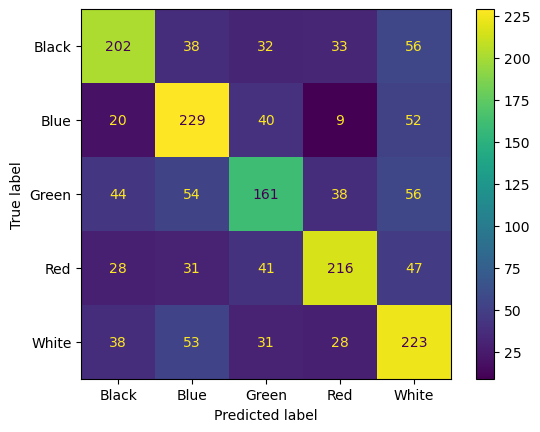

In [28]:
#Create confusion matrix of results
y_pred = bern_bigram.predict(test_X_CV350b_bigram)
cm=confusion_matrix(label_test_CV350b_bigram, y_pred, labels=bern_bigram.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=bern_bigram.classes_)
disp.plot()
plt.show()

In [29]:
#RBF Kernel
RBFSVMb = svm.SVC(kernel = "rbf")

In [30]:
#Training the model on the vectorized data
RBFSVMb.fit(train_X_CV350b_bigram, label_train_CV350b_bigram)

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


SVC()

In [31]:
#Test the model against the testing data
RBFSVMb.score(test_X_CV350b_bigram, label_test_CV350b_bigram)

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


0.6522222222222223

/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/bryandamico/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


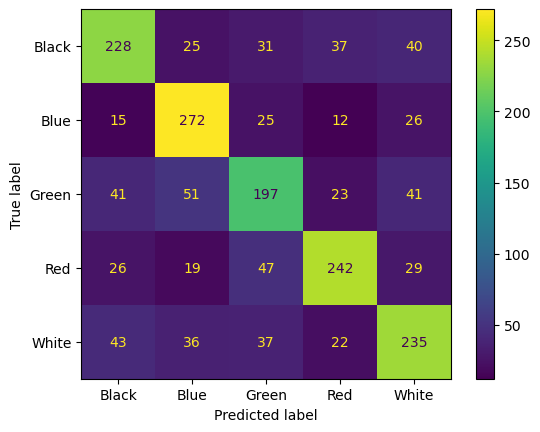

In [32]:
#Create confusion matrix of results
y_pred = RBFSVMb.predict(test_X_CV350b_bigram)
cm=confusion_matrix(label_test_CV350b_bigram, y_pred, labels=RBFSVMb.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=RBFSVMb.classes_)
disp.plot()
plt.show()